In [1]:
import numpy as np
import collections
import gzip
import random

from scipy import stats
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [2]:
f_vcf = "/cbscratch/franco/datasets/gtex/genotypes/vcfs_allsamples/GTEx_Analysis_20150112_OMNI_2.5M_5M_450Indiv_imput_info04_PASS_maf01_HWEp1E6_dbSNP135_ConstrVarIDs_chr1.vcf.gz"

In [3]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def HWEcheck(x):
    gt = x.tolist()
    f = np.array([0] * 3)
    f[0] = gt.count(0)
    f[1] = gt.count(1)
    f[2] = gt.count(2)
    n = sum(f)
    #p_A = (2 * f[0] + f[1]) / (2 * n)
    #p_a = (2 * f[2] + f[1]) / (2 * n)
    X2 = n * ( (4 * f[0] * f[2] - f[1] ** 2) / ((2 * f[0] + f[1]) * (2 * f[2] + f[1])) )**2
    pval = 1 - stats.chi2.cdf(X2, 1)
    return pval

def filter_snps(snpinfo, dosage):
    # Predixcan style filtering of snps
    newsnps = list()
    newdosage = list()
    npoly = 0
    nambi = 0
    nunkn = 0
    nlowf = 0
    nhwep = 0
    for i, snp in enumerate(snpinfo):
        pos = snp.bp_pos
        refAllele = snp.ref_allele
        effectAllele = snp.alt_allele
        rsid = snp.varid
        maf = round(snp.maf, 3)
        # Skip non-single letter polymorphisms
        if len(refAllele) > 1 or len(effectAllele) > 1:
            npoly += 1
            continue
        # Skip ambiguous strands
        if SNP_COMPLEMENT[refAllele] == effectAllele:
            nambi += 1
            continue
        # Skip unknown RSIDs
        if rsid == '.':
            nunkn += 1
            continue
        # Skip low MAF
        if not (maf >= 0.10 and maf <=0.90):
            nlowf += 1
            continue
        # Convert to integers 0, 1 or 2
        bins = [0.66, 1.33]
        intdosage = np.digitize(dosage[i], bins)
        # Remove SNPs out of HWE
        hwep = HWEcheck(intdosage)
        if(hwep < 0.000001):
            nhwep += 1
            # self.logger.debug("SNP {:s} has a HWE p-value of {:g}".format(rsid, hwep))
            continue
        newsnps.append(snp)
        newdosage.append(dosage[i])
        # newdosage.append(intdosage)
    print("Removed {:d} SNPs because of non-single letter polymorphisms".format(npoly))
    print("Removed {:d} SNPs because of ambiguous strands".format(nambi))
    print("Removed {:d} SNPs because of unknown RSIDs".format(nunkn))
    print("Removed {:d} SNPs because of low MAF < 0.10".format(nlowf))
    print("Removed {:d} SNPs because of deviation from HWE".format(nhwep))
    return newsnps, np.array(newdosage)    

def read_vcf(filename, startsnp, endsnp):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    dsindx = linesplit[8].split(':').index("DS")
                    ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                    gtindx = linesplit[8].split(':').index("GT")
                    for i, x in enumerate(ds):
                        if x == ".":
                            gt = linesplit[9+i].split(':')[gtindx]
                            if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                ds[i] = float(int(gt[0]) + int(gt[2]))

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1
                
                if linenum > endsnp:
                    break
    return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
    return gtcent, gtnorm

def sample_gt(snpinfo, nsample):
    nsnps = len(snpinfo)
    dosages = np.zeros(nsnps * nsample)
    i = 0
    for snp in snpinfo:
        gtcent = sample_from_maf(nsample, snp.maf)
        dosages[i,:] = gtcent
        i += 1
    return dosages    

def sample_from_maf(nsample, maf):
    dosage = np.zeros(nsample)
    mafratios = np.array([(1 - maf)**2, 2 * maf * (1 - maf), maf**2])
    nfreq  = np.random.multinomial(nsample, mafratios, size=1)[0]
    f1 = np.repeat(0, nfreq[0])
    f2 = np.repeat(1, nfreq[1])
    f3 = np.repeat(2, nfreq[2])
    x  = np.concatenate((f1,f2,f3))
    dosage = np.random.permutation(x)
    # gtnorm = (dosage - (2 * maf2d)) / np.sqrt(2 * maf2d * (1 - maf2d))
    gtcent = dosage - np.mean(dosage)

    return gtcent

def simulate_gt(nsnps, nsample):
    mafs = np.linspace(0.1, 0.9, nsnps)
    gtcent = np.zeros((nsnps, nsample))
    snpinfo = list()
    for i in range(nsnps):
        gtcent[i,:] = sample_from_maf(nsample, mafs[i])
        this_snp = SnpInfo(chrom      = 1,
                           bp_pos     = i*100,
                           varid      = "rsid"+str(i),
                           ref_allele = "A",
                           alt_allele = "G",
                           maf        = mafs[i])
        snpinfo.append(this_snp)
    return gtcent, snpinfo

def gx_knn_correction(expr):
    pca = PCA(n_components=min(expr.shape[0], expr.shape[1]))
    print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
    print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = 15
    gx_knn = np.zeros_like(expr)

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)

    return gx_knn

def knn_correction(expr, dosage):
    pca = PCA(n_components=min(expr.shape[0], expr.shape[1]))
    print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
    print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = 30
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, neighbors[1:]], axis = 1)

    return gx_knn, gt_knn

In [4]:
# Use real genotype
gtfull, snp_info, gt_donors = read_vcf(f_vcf, 0, 20000)
snp_info, gtfull = filter_snps(snp_info, gtfull)

# Use artificial genotype
# gtfull, snp_info = simulate_gt(10000, len(gt_donors))


Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 532 SNPs because of low MAF < 0.10
Removed 525 SNPs because of deviation from HWE


In [5]:
# # Simulate some expression
# ngene = 15000
# nsample = 350
# gx_rand = np.random.normal(0, 1, size = nsample * ngene).reshape((ngene, nsample)) 
# gx_donors = random.sample(gt_donors, nsample)
# print(gx_rand.shape)

# Load real expression
import pandas as pd
# df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess/gtex/expression/lmcorrected_it/ms_lmcorrected.txt", header=0, index_col=0, sep="\t")
# df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess/gtex/expression/lasso/ms_lasso.txt", header=0, index_col=0, sep="\t")
df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess/gtex/expression/normalized/ms_normalized.txt.protein_coding_filtered", header=0, index_col=0, sep="\t")
ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
print(gx.shape)
print(np.linalg.matrix_rank(gx))


(15158, 361)
361


In [6]:
# # PCA correction

from sklearn.decomposition import PCA
# nComp = 5
# pca = PCA()
# pca.fit(gx_rand.T)
# gx_rand_pca = np.dot(pca.transform(gx_rand.T)[:, nComp:], pca.components_[nComp:,:]).T
# print(gx_rand_pca.shape)
# gx_rand_pca_norm = normalize_expr(gx_rand_pca[:, exprmask]) #/ np.sqrt(nsample)


In [7]:
import copy
vcfmask, exprmask = select_donors(gt_donors, gx_donors)

gx_norm = normalize_expr(gx[:, exprmask] )
gt_full = gtfull[:, vcfmask]

shuffle_mask = np.arange(nsample)
np.random.shuffle(shuffle_mask)

gx_shuffled_norm = copy.deepcopy(gx_norm[:, shuffle_mask])

gx_knn, gt_knn = knn_correction(gx_norm.T, gt_full)

gx_knn_norm = normalize_expr(gx_knn.T)
gt_knn_cent, _gt = normalize_and_center_dosage(gt_knn, snp_info)
gt_cent, _gt = normalize_and_center_dosage(gt_full, snp_info)

gx_shuffled_knn_norm = copy.deepcopy(gx_knn_norm[:, shuffle_mask])

sigmax2 = np.var(gt_cent, axis = 1)

Original dimension: 361 x 15158
Reduced dimension: 361 x 361


In [8]:
# Y = gx_knn_norm
# Yt = Y.T
# U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
# print(U.shape)


# print(gt_knn_cent.shape)
# Ugt_knn_cent = np.zeros(gt_knn_cent.shape)
# for i in range(gt_knn_cent.shape[0]):
#     Ugt_knn_cent[i,:] = np.dot(U.T, gt_knn_cent[i,:])
# print(Ugt_knn_cent.shape)

# # print(gx_shuffled_knn_norm.shape)
# print(gt_shuffled_knn_cent.shape)
# U, S, Vt = np.linalg.svd(gx_shuffled_knn_norm.T, full_matrices=False)

# Ugt_shuffled_knn_cent = np.zeros(gt_shuffled_knn_cent.shape)
# for i in range(gt_shuffled_knn_cent.shape[0]):
#     Ugt_shuffled_knn_cent[i,:] = np.dot(U.T, gt_shuffled_knn_cent[i,:])
# # print(Ugx_shuffled_knn_norm.shape)
# print(Ugt_shuffled_knn_cent.shape)

# Usigmax2knn = np.var(Ugt_knn_cent, axis=1)

4612.826397860492


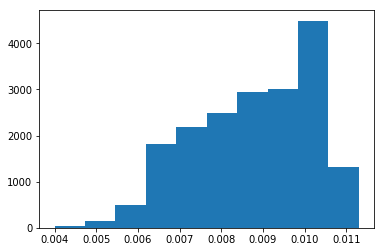

In [9]:
Y = gx_norm # / np.sqrt(nsample)
Yt = Y.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
s2_median = np.median(np.square(S))
print(s2_median)
SIGMA_BETAS = np.sqrt( sigmax2 / s2_median )
plt.hist(SIGMA_BETAS)
plt.show()

In [10]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

====== Norm KNN ======
MEDIAN S2 7135.154581921948
SIGMAX2 0.16399050484572708
First singular values: [515.67159664 442.57644934 423.33989118 402.12226231 397.13092161]
SX2/SB2: 0.16399050484572708 / 3.555098126428272e-05 = 4612.826397860491
K: 360
Keff: 229.141444
Keffs mean: 229.14144419720367
Keffs std: 5.678637577683526e-14
====== Shuffled Norm KNN ======
MEDIAN S2 7135.154581921948
SIGMAX2 0.16399050484572708
First singular values: [515.67159664 442.57644934 423.33989118 402.12226231 397.13092161]
SX2/SB2: 0.16399050484572708 / 3.555098126428272e-05 = 4612.826397860491
K: 360
Keff: 229.141444
Keffs mean: 229.14144419720373
Keffs std: 5.691838845217131e-14


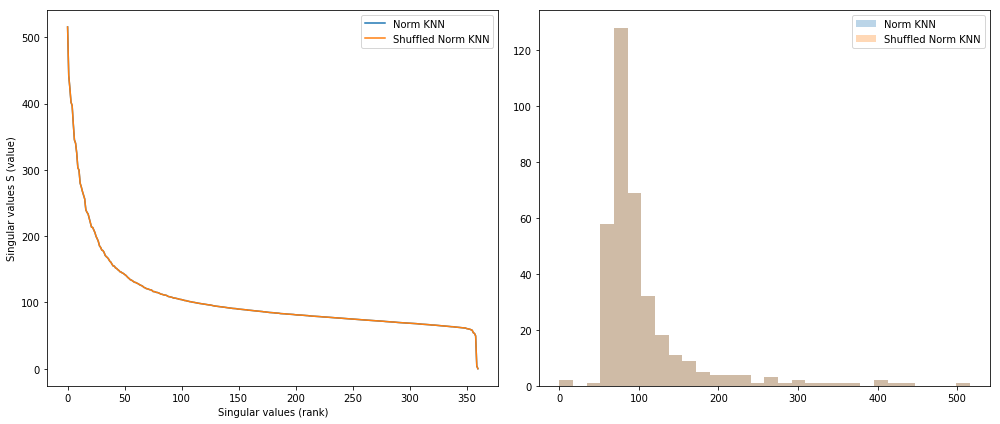

In [19]:
def compare_basic_props(GX, GT, ax1, ax2, label, sigmax2 = [0.1], sb2 = None, i = 0, Ucorr = False):
    # Yt = (GX / np.sqrt(nsample)).T
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    
    K = np.linalg.matrix_rank(GX)
    print("====== {:s} ======".format(label))
    print("MEDIAN S2", np.median(S2))
    print("SIGMAX2", sigmax2[i])
    
    print("First singular values:",S[:5])
    S2mod = S2 + sigmax2[i] / sb2[i]
    Keff = np.sum(S2 / S2mod)
    print("SX2/SB2:",sigmax2[i], "/", sb2[i], "=", sigmax2[i]/sb2[i])    
    print("K: {:d}".format(K))
    print("Keff: {:f}".format(Keff))
        
    ax1.plot(np.arange(len(S)), S, label = label)
    ax2.hist(S, bins=30, alpha=0.3, label = label)
    
    nsnps = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    mu2    = np.zeros(nsnps)
    mu4    = np.zeros(nsnps)
    Keffs  = np.zeros(nsnps)
    for j in range(nsnps):       
        S2mod = S2 + sigmax2[j] / sb2[j]
        
        Keffs[j] = np.sum(S2 / S2mod)
        if Ucorr:
            W = np.diag(S2 / S2mod) / sigmax2[j]
            Rscore[j] = np.sum(np.square(GT[j,:]) * (S2 / S2mod)) / sigmax2[j]
        else:
            W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2[j]
            Rscore[j] = np.sum(np.square(np.dot(U.T, GT[j,:])) * (S2 / S2mod)) / sigmax2[j]
        
        pvals[j], muQ[j], sigmaQ[j] = pvals_perm(GT[j, :].reshape(1, -1), Rscore[j], W)
        mu2[j], mu4[j] = moment_data(GT[j, :].reshape(1, -1))
        
    print("Keffs mean:", np.mean(Keffs))
    print("Keffs std:", np.std(Keffs))
        
#     print("Qscore:", Rscore[:5])
#     print("muQ:", muQ[:5])
#     print("sigmaQ:", sigmaQ[:5])
#     print("pvals:", pvals[:5])
    return S2, pvals, Rscore, muQ, sigmaQ, mu2, mu4

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sb2 = np.square(SIGMA_BETAS)
i = 0

# S2, pvals, Qscores, muQ, scaledQ, mu2, mu4                                       = compare_basic_props(gx_norm, gt_cent, ax1, ax2, 'Norm', sigmax2 = sigmax2, sb2 = sb2, i = i)
# S2, shuffled_pvals, shuffled_Qscores, shuffled_muQ, shuffled_scaledQ, Smu2, Smu4 = compare_basic_props(gx_shuffled_norm, gt_cent, ax1, ax2, 'Shuffled Norm', sigmax2 = sigmax2, sb2 = sb2, i = i)
# S2knn, pvalsknn, Qscoresknn, muQknn, scaledQknn, mu2knn, mu4knn                                              = compare_basic_props(gx_knn_norm, gt_cent, ax1, ax2, 'Norm KNN', sigmax2 = sigmax2, sb2 = sb2, i = i)
# S2knn, shuffled_pvalsknn, shuffled_Qscoresknn, shuffled_muQknn, shuffled_scaledQknn, Smu2knn, Smu4knn        = compare_basic_props(gx_shuffled_knn_norm, gt_cent, ax1, ax2, 'Shuffled Norm KNN', sigmax2 = sigmax2, sb2 = sb2, i = i)

S2knn2, pvalsknn2, Qscoresknn2, muQknn2, scaledQknn2, mu2knn2, mu4knn2                                              = compare_basic_props(gx_knn_norm, gt_knn_cent, ax1, ax2, 'Norm KNN', sigmax2 = sigmax2, sb2 = sb2, i = i)
S2knn2, shuffled_pvalsknn2, shuffled_Qscoresknn2, shuffled_muQknn2, shuffled_scaledQknn2, Smu2knn2, Smu4knn2        = compare_basic_props(gx_shuffled_knn_norm, gt_knn_cent, ax1, ax2, 'Shuffled Norm KNN', sigmax2 = sigmax2, sb2 = sb2, i = i)

# US2knn, Upvalsknn, UQscoresknn, UmuQknn, UscaledQknn, Umu2knn, Umu4knn                                       = compare_basic_props(gx_knn_norm, Ugt_knn_cent, ax1, ax2, 'Norm U KNN', sigmax2 = Usigmax2knn, sb2 = sb2, i = i, Ucorr=True)
# US2knn, Ushuffled_pvalsknn, Ushuffled_Qscoresknn, Ushuffled_muQknn, Ushuffled_scaledQknn, USmu2knn, USmu4knn = compare_basic_props(gx_shuffled_knn_norm, Ugt_shuffled_knn_cent, ax1, ax2, 'U Shuffled Norm KNN', sigmax2 = Usigmax2knn, sb2 = sb2, i = i, Ucorr=True)

ax1.set_xlabel("Singular values (rank)")
ax1.set_ylabel("Singular values S (value)")
ax1.legend()

ax2.legend()
plt.tight_layout()
plt.show()


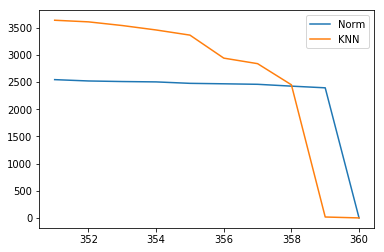

In [12]:
plt.plot(np.arange(len(S2))[-10:], S2[-10:], label = "Norm")
plt.plot(np.arange(len(S2))[-10:], S2knn[-10:], label="KNN")
plt.legend()
plt.show()

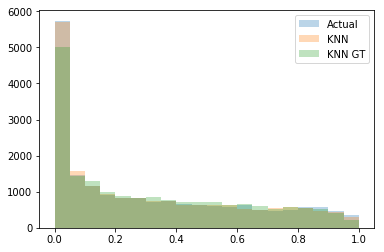

In [25]:
plt.hist(pvals, bins=20, alpha=0.3, label="Actual")
# plt.hist(shuffled_pvals, bins=20, alpha=0.3, label="Shuffled")
plt.hist(pvalsknn, bins=20, alpha=0.3, label="KNN")
# plt.hist(shuffled_pvalsknn, bins=20, alpha=0.3, label="Shuffled KNN")
plt.hist(pvalsknn2, bins=20, alpha=0.3, label="KNN GT")
# plt.hist(shuffled_pvalsknn2, bins=20, alpha=0.3, label="Shuffled KNN GT")



# plt.hist(Upvalsknn, bins=20, alpha=0.3, label="U KNN")
# plt.hist(Ushuffled_pvalsknn, bins=20, alpha=0.3, label="U Shuffled KNN")
plt.legend()
plt.show()


In [ ]:
def read_tejaas_rr_pvals(filename):
    # print("Loading ", filename)
    pvals = list()
    with open(filename, "r") as mfile:
        next(mfile)
        for line in mfile:
            pvals.append(float(line.split()[5]))
    pvals = np.array(pvals)
    return pvals

# rrfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_dynamic_sb2/norm/gtex-ms/tejaas/permnull_sb0.1/chr1/rr.txt"
rrfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_sqrt_dynamic_nocismask/norm/gtex-ms/tejaas/permnull_sb0.05/chr1/chunk000_rr.txt"
bsub_pvals = read_tejaas_rr_pvals(rrfile)

In [ ]:
pvals[:10]

In [ ]:
# plt.scatter(-np.log10(pvals), -np.log10(bsub_pvals[:len(pvals)]), alpha=0.1)
plt.scatter(pvals, bsub_pvals[:len(pvals)], alpha=0.1)
# plt.scatter(-np.log10(pvals), -np.log10(pvalsknn), alpha=0.1)
plt.show()

In [ ]:
qscaled = (Qscores - muQ)/ scaledQ
shuffled_qscaled = (shuffled_Qscores - shuffled_muQ)/ shuffled_scaledQ

# Uqscaled = (UQscoresknn - UmuQknn)/ UscaledQknn
# Ushuffled_qscaled = (Ushuffled_Qscoresknn - Ushuffled_muQknn)/ Ushuffled_scaledQknn

qscaledknn = (Qscoresknn - muQknn)/ scaledQknn
shuffled_qscaledknn = (shuffled_Qscoresknn - shuffled_muQknn)/ shuffled_scaledQknn
# # Ushuffled_qscaledknn = (Ushuffled_Qscoresknn - Ushuffled_muQknn)/ Ushuffled_scaledQknn


plt.hist(qscaled, bins=30, alpha=0.3, density=True, label="Actual")
plt.hist(shuffled_qscaled, bins=30, alpha=0.3, density=True, label="Shuffled")

# plt.hist(Uqscaled, bins=30, alpha=0.3, density=True, label="Actual")
# plt.hist(Ushuffled_qscaled, bins=30, alpha=0.3, density=True, label="Shuffled")

plt.hist(qscaledknn, bins=30, alpha=0.3, density=True, label="Actual KNN")
plt.hist(shuffled_qscaledknn, bins=30, alpha=0.3, density=True, label="Shuffled KNN")


x = np.linspace(-4, 4, 100)

rv = stats.norm(loc = 0, scale = 1)
plt.plot(x, rv.pdf(x), label = 'analytical')
plt.legend()
plt.show()

In [ ]:
plt.hist(Qscores, bins=50, alpha = 0.3, label="actual")
plt.hist(shuffled_Qscores, bins=50, alpha = 0.3, label="shuffled")
plt.show()

In [ ]:
plt.scatter(Qscores, sigmax2, alpha=0.1)

In [ ]:
plt.scatter(shuffled_Qscores, sigmax2, alpha=0.1)

In [ ]:
print(np.mean(qscaled))
print(np.mean(shuffled_qscaled))

print(np.std(qscaled))
print(np.std(shuffled_qscaled))

In [ ]:
print(mu2)
print(Smu2)
print(mu2/Smu2)

In [ ]:
print(mu4)
print(Smu4)
print(mu4/Smu4)

In [ ]:
## Shuffle 1000 times, and get Qscore
def shuffle_and_plot(GX, GT, ax, label, snpinfo, sigmabeta2 = 0.5 * 0.5, sigmax2 = 0.35):
    niter = 20000
        
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    
    S2 = np.square(S)
    K = np.linalg.matrix_rank(GX)
    S2mod = S2 + sigmax2 / sigmabeta2
    
    print("====== {:s} ======".format(label))
    # print("First singular values:",S2[:5])
    myKeff = np.sum(S2 > (sigmax2/sigmabeta2))
    Keff = np.sum(S2 / S2mod)
    print("SX2/SB2:",sigmax2, "/", sigmabeta2, "=", sigmax2/sigmabeta2)    
    print("K: {:d}".format(K))
    print("Keff: {:f}".format(Keff))
    # print("myKeff: {:d}".format(myKeff))

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Qscore = np.sum(np.square(np.dot(U.T, GT)) * (S2 / S2mod)) / sigmax2
    
    pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
    
    Qiter = np.zeros(niter)
    permgt = GT.copy()
    norm = np.sqrt(np.linalg.norm(permgt))
    print("MAF",snpinfo.maf)
    nsample = GT.shape[0]
    for i in range(niter):
        np.random.shuffle(permgt)
#         permgt = sample_from_maf(nsample, snpinfo.maf)
        Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)) * (S2 / S2mod)) / sigmax2
    
    print("{:6g} | {:6g} | {:6g} | {:6g}\n".format(Qscore, muQ, sigmaQ, pval))
#     print("Qscore:", Qscore)
#     print("muQ:", muQ)
#     print("sigmaQ:", sigmaQ)
    
#     xmax = muQ + 4.0 * sigmaQ
#     xmin = muQ - 4.0 * sigmaQ
# #     bins = 50
#     bins = np.linspace(xmin, xmax, 200)
#     xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
#     x = np.linspace(xbin[0], xbin[-1], 100)
#     ax.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
#     ax.axvline(Qscore, color="red")
#     rv = stats.norm(loc = muQ, scale = sigmaQ)
#     ax.plot(x, rv.pdf(x), label = 'analytical')    
#     ax.set_title(label)
    
    xmax = 0.0 + 4.0 * 1.0
    xmin = 0.0 - 4.0 * 1.0
#     bins = 50
    bins = np.linspace(xmin, xmax, 200)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    Qiter = ( Qiter - muQ ) / sigmaQ
    ax.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
    ax.axvline((Qscore - muQ)/sigmaQ, color="red")
    rv = stats.norm(loc = 0, scale = 1)
    ax.plot(x, rv.pdf(x), label = 'analytical')    
    ax.set_title(label)
    
    return Qiter
    
fig = plt.figure(figsize = (16, 16))
# fig = plt.figure(figsize = (14, 26))

sb2 = np.square(SIGMA_BETAS)

i = 2 # 6309
print(snp_info[i])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
Qiter_norm = shuffle_and_plot(gx_shuffled_norm, gt_shuffled_cent[i, :], ax1, "Shuffled Norm "+str(i), snp_info[i], sigmabeta2 = sb2[i], sigmax2 = sigmax2[i])
# Qiter_norm = shuffle_and_plot(gx_shuffled_knn_norm, Ugt_shuffled_knn_cent[i, :], ax2, "U Shuffled KNN "+str(i), snp_info[i], sigmabeta2 = sb2[i], sigmax2 = sigmax2[i])
# Qiter_norm = shuffle_and_plot(gx_shuffled_knn_norm, gt_shuffled_knn_cent[i, :], ax3, "Shuffled KNN "+str(i), snp_info[i], sigmabeta2 = sb2[i], sigmax2 = sigmax2[i])


# for i in range(0,3,3):
#     ax1 = fig.add_subplot(5,3,i+1)
#     ax2 = fig.add_subplot(5,3,i+2)
#     ax3 = fig.add_subplot(5,3,i+3)
#     Qiter_norm = shuffle_and_plot(gx_norm, gt_cent[i, :], ax1, "Norm "+str(i), snp_info[i], sigmabeta2 = sb2[i], sigmax2 = sigmax2[i])
#     Qiter_knn = shuffle_and_plot(gx_knn_norm, gt_knn_cent[i, :], ax2, "Norm KNN ", snp_info[i], sigmabeta2 = sb2[i], sigmax2 = sigmax2[i])
#     Qiter_shuffle = shuffle_and_plot(gx_shuffled_norm, gt_shuffled_cent[i, :], ax3, "Norm Shuffle"+str(i), snp_info[i], sigmabeta2 = sb2[i], sigmax2 = sigmax2[i])
#     ax1.legend()

plt.tight_layout()
plt.show()


In [ ]:
## Shuffle 1000 times, and get Qscore
def svd_and_S2(Y, sigmax2, sigmabeta2):
    Yt = Y.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    
#     S = np.sort(np.random.normal(50, 10, size = S.shape[0]))
#     S[:2] = 1e-10
    
    S2 = np.square(S)
    K = S2.shape[0]
    S2mod = S2 + sigmax2 / sigmabeta2
    
    print("============")
    Keff = np.sum(S2 > (sigmax2/sigmabeta2))
    print("First S:", S2[:3])
    print("Last S:", S2[-3:])
    print("SX2/SB2:",sigmax2, "/", sigmabeta2, "=", sigmax2/sigmabeta2)    
    print("K: {:d}".format(K))
    print("Keff: {:d}".format(Keff))
    S2mod = S2 + sigmax2 / sigmabeta2
    S2_S2mod = S2 / S2mod
    print( "Sum of S2 / S2mod: {:g}".format(np.sum(S2_S2mod)) )
    
    return U, S2_S2mod

def shuffle_together_and_plot(niter, GX, GXPCA, GT, ax, sigmabeta2 = 0.5 * 0.5):
    sigmax2 = np.var(GT)
    nsample = GT.shape[0]
    
    U, S2_S2mod = svd_and_S2(GX, sigmax2, sigmabeta2)
    UPCA, S2_S2modPCA = svd_and_S2(GXPCA, sigmax2, sigmabeta2)
        
#     U, S2_S2mod = svd_and_S2(GX, sigmax2, sigmabeta2)
    W = np.dot(U, np.dot(np.diag(S2_S2mod), U.T))
    Qscore = np.sum(np.square(np.dot(U.T, GT)) * S2_S2mod)
    pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
    
#     UPCA, S2_S2modPCA = svd_and_S2(GXPCA, sigmax2, sigmabeta2)
    WPCA = np.dot(UPCA, np.dot(np.diag(S2_S2modPCA), UPCA.T))
    QscorePCA = np.sum(np.square(np.dot(UPCA.T, GT)) * S2_S2modPCA)
    pvalPCA, muQPCA, sigmaQPCA = pvals_perm(GT.reshape(1, -1), Qscore, WPCA)
    
    svalues = S2_S2mod
    svaluesPCA = S2_S2modPCA
    
    Ugt = np.zeros(niter * nsample)
    UgtPCA = np.zeros(niter * nsample)
    Qiter = np.zeros(niter)
    QiterPCA = np.zeros(niter)
    permgt = GT.copy()
    for i in range(niter):
        np.random.shuffle(permgt)
        
        Ugt[i*nsample : i*nsample + nsample] = np.square(np.dot(U.T, permgt)) # size 350
        Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)) * S2_S2mod)
        
        UgtPCA[i*nsample : i*nsample + nsample] = np.square(np.dot(UPCA.T, permgt))
        QiterPCA[i] = np.sum(np.square(np.dot(UPCA.T, permgt)) * S2_S2modPCA)
    
    
    return Qiter, QiterPCA, Ugt, svalues, UgtPCA, svaluesPCA
    
sb2 = 0.05 * 0.05
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

niter = 1000
Qiter, QiterPCA, Ugt, svalues, UgtPCA, svaluesPCA = shuffle_together_and_plot(niter, gx_rand_norm, gx_rand_pca_norm, gt[0, :], ax1, sigmabeta2 = sb2)

ax1.scatter(Qiter, QiterPCA, alpha = 0.3)
ax1.set_xlabel("Norm")
ax1.set_ylabel("Norm + PCA") 
ax2.hist(Qiter, bins=50, alpha=0.3, density=True, label="Random Norm")
ax2.hist(QiterPCA, bins=50, alpha=0.3, density=True, label="Random Norm PCA")

# Qiter_cent = (Qiter - np.mean(Qiter)) #/ np.std(Qiter)
# QiterPCA_cent = (QiterPCA - np.mean(QiterPCA)) #/ np.std(QiterPCA)

# ax1.scatter(Qiter_cent, QiterPCA_cent, alpha = 0.3)
# ax1.set_xlabel("Norm")
# ax1.set_ylabel("Norm + PCA") 

# ax2.hist(Qiter_cent, bins=50, alpha=0.3, density=True, label="Random Norm")
# ax2.hist(QiterPCA_cent, bins=50, alpha=0.3, density=True, label="Random Norm PCA")


ax2.legend()
plt.tight_layout()
plt.show()